In [ ]:
# # To unzip
# from zipfile import ZipFile
# file_name = "/content/drive/MyDrive/Colab Notebooks/Melanoma_Skin_Cancer_Detection/dataset.zip"
# with ZipFile(file_name, 'r') as zip:
#   zip.extractall()
#   print('done')

In [2]:
# import tensorflow as tf
# tf.test.gpu_device_name()

In [3]:
# #  Which GPU Am I Using?
# from tensorflow.python.client import device_lib
# device_lib.list_local_devices()

In [4]:
# # Install NVIDIA Drivers
# !nvidia-smi

In [4]:
# Download Drivers
# https://www.nvidia.com/en-us/drivers/
# Enter your GPU details and download the appropriate drivers.
# Follow the installation instructions for your operating system.

In [6]:
# Install CUDA Toolkit - Check Compatibility
# https://developer.nvidia.com/cuda-gpus

# Install CUDA
# https://developer.nvidia.com/cuda-downloads

# Verify CUDA Installation: Run
# !nvcc --version

In [ ]:
# Download cuDNN
# https://developer.nvidia.com/cudnn



In [5]:
# # Install Python Libraries for GPU
# !pip install tensorflow
# !pip install torch torchvision torchaudio 
# --index-url https://download.pytorch.org/whl/cuXX

In [7]:
# import tensorflow as tf
# print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))


In [9]:
# import torch

# print("Is CUDA available:", torch.cuda.is_available())
# print("GPU Device Name:", torch.cuda.get_device_name(0))


# Split dataset to Train, Validate and Test

In [10]:
!pip install split-folders

import splitfolders
import os

data_path = os.path.join('..', 'artifacts', 'dataset', 'raw', 'train')
# data_path = os.path.join('..', 'artifacts', 'dataset', 'processed', 'train')

splitfolders.ratio(data_path, 
                   'data',
                   seed = 41,
                   ratio = (0.6, 0.25, 0.15)) # train/val/test

Copying files: 9605 files [00:53, 179.56 files/s]


# Start to Training

In [11]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16, MobileNet, ResNet50, DenseNet121, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [12]:
# Function to create a model with a given base model
def create_transfer_learning_model(base_model, num_classes):
    base_model.trainable = False  # Freeze base model layers
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')(x)
    model = Model(inputs, outputs)
    return model

# Function to train a specific model
def train_model(model, train_generator, val_generator, epochs=10, learning_rate=0.001):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy' if train_generator.num_classes > 1 else 'binary_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=epochs,
                        steps_per_epoch=100)

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    accuracy_image_path = 'accuracy_plot.png'
    plt.plot(epochs, acc, label='training accuracy')
    plt.plot(epochs, val_acc, label='validation accuracy')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('Training validation Accuracy')
    plt.savefig(accuracy_image_path, bbox_inches='tight')
    plt.show()

    loss_image_path = 'loss_plot.png'
    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Training validation Loss')
    plt.savefig(loss_image_path, bbox_inches='tight')
    plt.show()

    return model, history

# Functions to create specific models
def create_vgg16_model(num_classes):
    return create_transfer_learning_model(VGG16(weights='imagenet', include_top=False), num_classes)

def create_mobilenet_model(num_classes):
    return create_transfer_learning_model(MobileNet(weights='imagenet', include_top=False), num_classes)

def create_resnet50_model(num_classes):
    return create_transfer_learning_model(ResNet50(weights='imagenet', include_top=False), num_classes)

def create_densenet_model(num_classes):
    return create_transfer_learning_model(DenseNet121(weights='imagenet', include_top=False), num_classes)

def create_inceptionv3_model(num_classes):
    return create_transfer_learning_model(InceptionV3(weights='imagenet', include_top=False), num_classes)

# Function to save the model
def save_model(model, filepath):
    model.save(filepath)
    print(f"Model saved to {filepath}")

# Function to load the model
def load_model(filepath):
    model = tf.keras.models.load_model(filepath)
    print(f"Model loaded from {filepath}")
    return model

# Function to evaluate the model
def evaluate_model(model, test_generator):
    predictions = model.predict(test_generator)

    predicted_classes = np.argmax(predictions, axis=1) if test_generator.num_classes > 1 else (predictions > 0.5).astype(int)

    # Handle binary and multiclass cases
    # if test_generator.num_classes > 1:  # Multiclass classification
    #     predicted_classes = np.argmax(predictions, axis=1)
    # else:  # Binary classification
    #     predicted_classes = (predictions > 0.5).astype(int).flatten()

    true_classes = test_generator.classes
    # class_indices = test_generator.class_indices

    # Metrics
    acc = accuracy_score(true_classes, predicted_classes)
    loss = 1 - acc
    cm = confusion_matrix(true_classes, predicted_classes)
    cr = classification_report(true_classes, predicted_classes)
    kappa = cohen_kappa_score(true_classes, predicted_classes)

    print(f"Accuracy: {acc}")
    print(f"Loss: {loss}")
    print(f"Cohen Kappa Score: {kappa}")
    print("Classification Report:")
    print(cr)

    # Plot confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

    return acc, kappa, cm, cr

# Function to prepare data generators
def prepare_data_generators(train_dir, val_dir, test_dir, target_size=(224, 224), batch_size=32):
    datagen = ImageDataGenerator(rescale=1.0/255)
    train_generator = datagen.flow_from_directory(train_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical')
    val_generator = datagen.flow_from_directory(val_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical')
    test_generator = datagen.flow_from_directory(test_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
    return train_generator, val_generator, test_generator


# VGG16

Found 5763 images belonging to 2 classes.
Found 2401 images belonging to 2 classes.
Found 1441 images belonging to 2 classes.


E:\Projects\Project Melanoma-Skin-Cancer-Detection\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 256s 3s/step - accuracy: 0.6944 - loss: 0.5623 - val_accuracy: 0.7888 - val_loss: 0.4227
Epoch 2/100
 81/100 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.8377 - loss: 0.3965

E:\Projects\Project Melanoma-Skin-Cancer-Detection\venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 226s 2s/step - accuracy: 0.8374 - loss: 0.3961 - val_accuracy: 0.8392 - val_loss: 0.3698
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.8488 - loss: 0.3598 - val_accuracy: 0.8571 - val_loss: 0.3428
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.8673 - loss: 0.3299 - val_accuracy: 0.8634 - val_loss: 0.3219
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.8710 - loss: 0.3078 - val_accuracy: 0.8667 - val_loss: 0.3259
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.8578 - loss: 0.3257 - val_accuracy: 0.8813 - val_loss: 0.2974
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.8718 - loss: 0.2953 - val_accuracy: 0.8830 - val_loss: 0.2853
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.8717 - loss: 0.2947 - val_accuracy: 0.8838 - val_loss: 0.2884
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.8976 - loss: 0.2568 - val_accuracy

Epoch 52/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 408s 4s/step - accuracy: 0.9242 - loss: 0.1890 - val_accuracy: 0.9134 - val_loss: 0.2191
Epoch 53/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 463s 5s/step - accuracy: 0.9070 - loss: 0.2076 - val_accuracy: 0.9013 - val_loss: 0.2482
Epoch 54/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 409s 4s/step - accuracy: 0.9172 - loss: 0.2089 - val_accuracy: 0.9096 - val_loss: 0.2222
Epoch 55/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 457s 5s/step - accuracy: 0.9336 - loss: 0.1768 - val_accuracy: 0.9100 - val_loss: 0.2231
Epoch 56/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 410s 4s/step - accuracy: 0.9292 - loss: 0.1716 - val_accuracy: 0.9084 - val_loss: 0.2353
Epoch 57/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 458s 5s/step - accuracy: 0.9139 - loss: 0.2046 - val_accuracy: 0.9130 - val_loss: 0.2173
Epoch 58/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 415s 4s/step - accuracy: 0.9215 - loss: 0.1894 - val_accuracy: 0.9121 - val_loss: 0.2185
Epoch 59/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 469s 5s/step - accuracy: 0.9210 - loss: 0

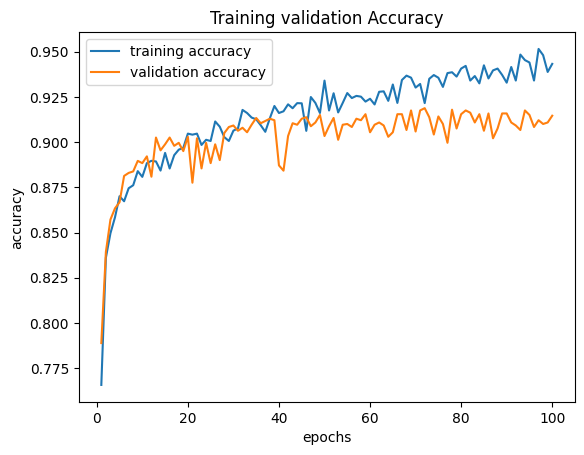

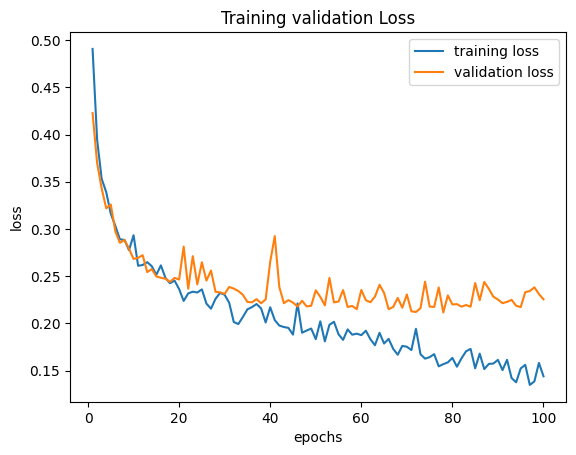

Model saved to vgg16_model.h5
Model loaded from vgg16_model.h5
46/46 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step
Accuracy: 0.9132546842470507
Loss: 0.0867453157529493
Cohen Kappa Score: 0.825890988668536
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       750
           1       0.93      0.89      0.91       691

    accuracy                           0.91      1441
   macro avg       0.91      0.91      0.91      1441
weighted avg       0.91      0.91      0.91      1441



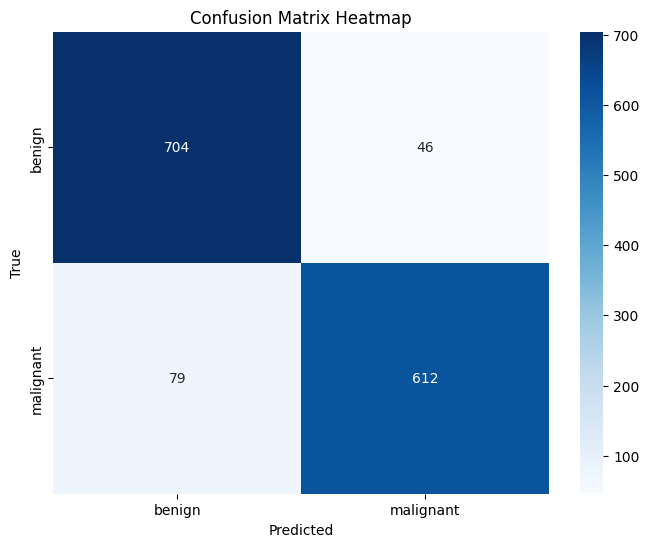

In [13]:
if __name__ == "__main__":
    # Paths to your data directories
    train_dir = os.path.join('data', 'train') # "/content/data/train"
    val_dir = os.path.join('data', 'val') # "/content/data/val"
    test_dir = os.path.join('data', 'test') # "/content/data/test"

    # Prepare data
    train_gen, val_gen, test_gen = prepare_data_generators(train_dir, val_dir, test_dir)

    # Choose number of classes
    num_classes = train_gen.num_classes

    # Train VGG16 model
    vgg16_model = create_vgg16_model(num_classes)
    trained_vgg16, _ = train_model(vgg16_model, train_gen, val_gen, epochs=100)
    save_model(trained_vgg16, "vgg16_model.h5")
    # save_model(trained_vgg16, "vgg16_model.keras")

    # Load and evaluate VGG16 model
    loaded_vgg16 = load_model("vgg16_model.h5")
    evaluate_model(loaded_vgg16, test_gen)

# Mobilenet

Found 5763 images belonging to 2 classes.
Found 2401 images belonging to 2 classes.
Found 1441 images belonging to 2 classes.


C:\Users\SURESH RAJPUROHIT\AppData\Local\Temp\ipykernel_3168\471771781.py:59: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  return create_transfer_learning_model(MobileNet(weights='imagenet', include_top=False), num_classes)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 28s 2us/step
Epoch 1/100


E:\Projects\Project Melanoma-Skin-Cancer-Detection\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 299ms/step - accuracy: 0.8247 - loss: 0.3972 - val_accuracy: 0.8784 - val_loss: 0.2763
Epoch 2/100
 81/100 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - accuracy: 0.9113 - loss: 0.2286

E:\Projects\Project Melanoma-Skin-Cancer-Detection\venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 262ms/step - accuracy: 0.9122 - loss: 0.2270 - val_accuracy: 0.9113 - val_loss: 0.2318
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 293ms/step - accuracy: 0.9184 - loss: 0.2081 - val_accuracy: 0.9088 - val_loss: 0.2294
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 262ms/step - accuracy: 0.9350 - loss: 0.1826 - val_accuracy: 0.8925 - val_loss: 0.2506
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 293ms/step - accuracy: 0.9294 - loss: 0.1769 - val_accuracy: 0.9038 - val_loss: 0.2342
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 262ms/step - accuracy: 0.9284 - loss: 0.1877 - val_accuracy: 0.9092 - val_loss: 0.2167
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 295ms/step - accuracy: 0.9308 - loss: 0.1566 - val_accuracy: 0.9196 - val_loss: 0.2117
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 263ms/step - accuracy: 0.9376 - loss: 0.1726 - val_accuracy: 0.9067 - val_loss: 0.2601
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 294ms/step - accuracy: 0.9521 - loss: 0.135

100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 293ms/step - accuracy: 1.0000 - loss: 7.8864e-04 - val_accuracy: 0.9163 - val_loss: 0.4440
Epoch 52/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 262ms/step - accuracy: 1.0000 - loss: 8.3867e-04 - val_accuracy: 0.9117 - val_loss: 0.4344
Epoch 53/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 292ms/step - accuracy: 1.0000 - loss: 8.5053e-04 - val_accuracy: 0.9117 - val_loss: 0.4381
Epoch 54/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 262ms/step - accuracy: 1.0000 - loss: 8.1570e-04 - val_accuracy: 0.9163 - val_loss: 0.4483
Epoch 55/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 293ms/step - accuracy: 1.0000 - loss: 7.0198e-04 - val_accuracy: 0.9146 - val_loss: 0.4565
Epoch 56/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 262ms/step - accuracy: 1.0000 - loss: 6.2326e-04 - val_accuracy: 0.9146 - val_loss: 0.4478
Epoch 57/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 295ms/step - accuracy: 1.0000 - loss: 7.8674e-04 - val_accuracy: 0.9163 - val_loss: 0.4574
Epoch 58/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 261ms/st

Epoch 99/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 29s 295ms/step - accuracy: 1.0000 - loss: 5.8691e-05 - val_accuracy: 0.9159 - val_loss: 0.5636
Epoch 100/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 264ms/step - accuracy: 1.0000 - loss: 5.2658e-05 - val_accuracy: 0.9146 - val_loss: 0.5646


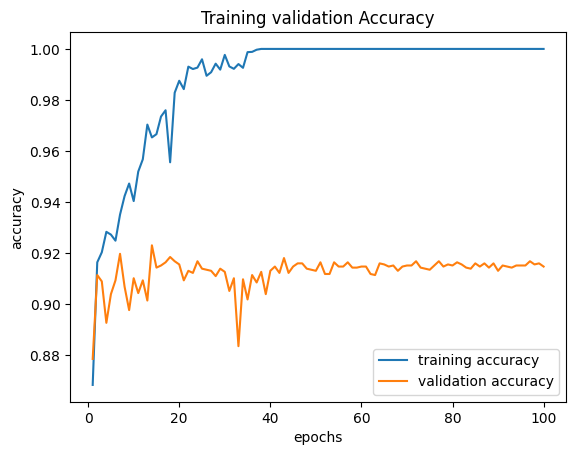

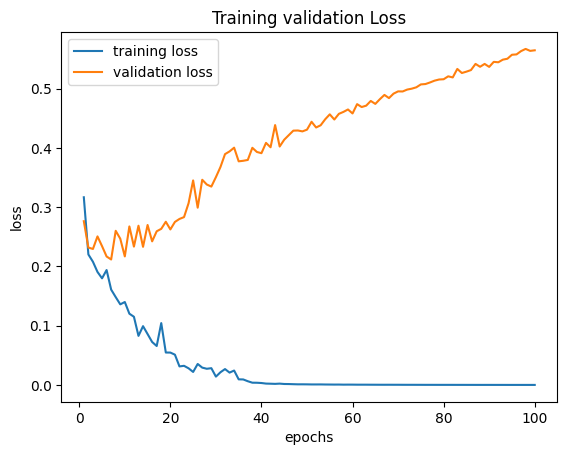

Model saved to mobilenet_model.h5


Model loaded from mobilenet_model.h5
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step
Accuracy: 0.919500346981263
Loss: 0.08049965301873696
Cohen Kappa Score: 0.8386201090566445
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       750
           1       0.92      0.91      0.92       691

    accuracy                           0.92      1441
   macro avg       0.92      0.92      0.92      1441
weighted avg       0.92      0.92      0.92      1441



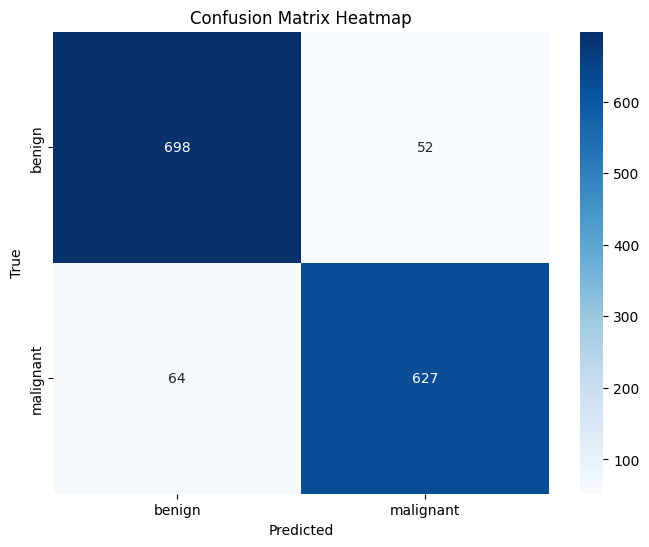

In [14]:
if __name__ == "__main__":
    # Paths to your data directories
    train_dir = os.path.join('data', 'train') # "/content/data/train"
    val_dir = os.path.join('data', 'val') # "/content/data/val"
    test_dir = os.path.join('data', 'test') # "/content/data/test"


    # Prepare data
    train_gen, val_gen, test_gen = prepare_data_generators(train_dir, val_dir, test_dir)]p

    # Choose number of classes
    num_classes = train_gen.num_classes

    # Train VGG16 model
    mobilenet_model = create_mobilenet_model(num_classes)
    trained_mobilenet, _ = train_model(mobilenet_model, train_gen, val_gen, epochs=100)
    save_model(trained_mobilenet, "mobilenet_model.h5")

    # Load and evaluate VGG16 model
    loaded_mobilenet = load_model("mobilenet_model.h5")
    evaluate_model(loaded_mobilenet, test_gen)

# Resnet50

Found 5763 images belonging to 2 classes.
Found 2401 images belonging to 2 classes.
Found 1441 images belonging to 2 classes.
Epoch 1/100


E:\Projects\Project Melanoma-Skin-Cancer-Detection\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 97s 936ms/step - accuracy: 0.5469 - loss: 0.7484 - val_accuracy: 0.5323 - val_loss: 0.7287
Epoch 2/100
 81/100 ━━━━━━━━━━━━━━━━━━━━ 10s 527ms/step - accuracy: 0.5886 - loss: 0.6584

E:\Projects\Project Melanoma-Skin-Cancer-Detection\venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 824ms/step - accuracy: 0.5935 - loss: 0.6571 - val_accuracy: 0.4956 - val_loss: 0.6509
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 93s 931ms/step - accuracy: 0.6211 - loss: 0.6313 - val_accuracy: 0.7430 - val_loss: 0.6114
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 834ms/step - accuracy: 0.6647 - loss: 0.6074 - val_accuracy: 0.7509 - val_loss: 0.5874
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 92s 923ms/step - accuracy: 0.7208 - loss: 0.5773 - val_accuracy: 0.7309 - val_loss: 0.5620
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 83s 830ms/step - accuracy: 0.6931 - loss: 0.5749 - val_accuracy: 0.6918 - val_loss: 0.5603
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 92s 926ms/step - accuracy: 0.7266 - loss: 0.5490 - val_accuracy: 0.6743 - val_loss: 0.5790
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 819ms/step - accuracy: 0.7452 - loss: 0.5301 - val_accuracy: 0.6972 - val_loss: 0.5705
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 92s 924ms/step - accuracy: 0.7317 - loss: 0.525

100/100 ━━━━━━━━━━━━━━━━━━━━ 92s 922ms/step - accuracy: 0.8049 - loss: 0.4008 - val_accuracy: 0.8247 - val_loss: 0.3896
Epoch 52/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 826ms/step - accuracy: 0.8335 - loss: 0.3910 - val_accuracy: 0.8138 - val_loss: 0.3913
Epoch 53/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 92s 925ms/step - accuracy: 0.8223 - loss: 0.3974 - val_accuracy: 0.8101 - val_loss: 0.3921
Epoch 54/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 827ms/step - accuracy: 0.8214 - loss: 0.4049 - val_accuracy: 0.8226 - val_loss: 0.4294
Epoch 55/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 93s 929ms/step - accuracy: 0.8275 - loss: 0.3964 - val_accuracy: 0.7497 - val_loss: 0.4933
Epoch 56/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 821ms/step - accuracy: 0.8084 - loss: 0.4149 - val_accuracy: 0.8226 - val_loss: 0.3796
Epoch 57/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 92s 923ms/step - accuracy: 0.8269 - loss: 0.3850 - val_accuracy: 0.5506 - val_loss: 0.7769
Epoch 58/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 826ms/step - accuracy: 0.7816 - loss

100/100 ━━━━━━━━━━━━━━━━━━━━ 82s 827ms/step - accuracy: 0.8394 - loss: 0.3599 - val_accuracy: 0.8326 - val_loss: 0.3628


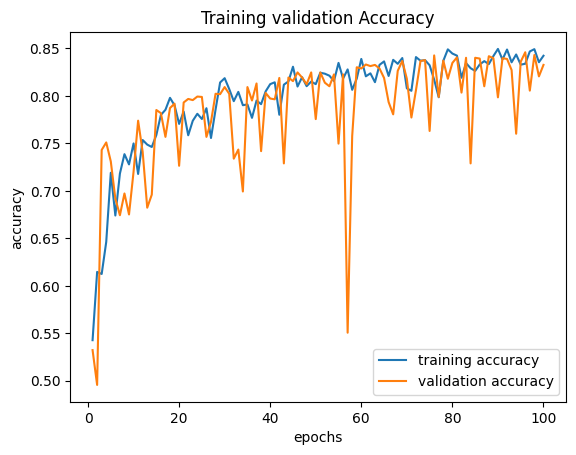

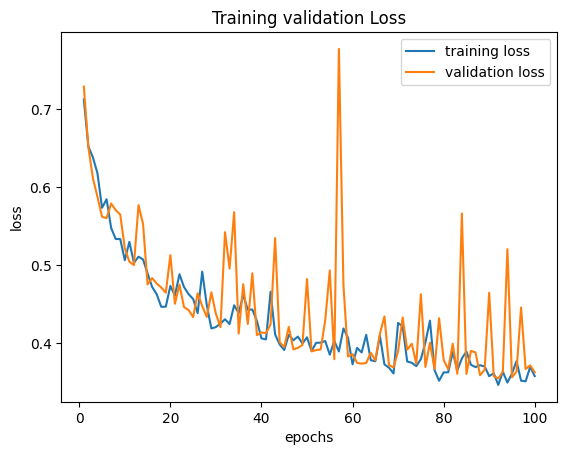

Model saved to resnet50_model.h5


Model loaded from resnet50_model.h5
46/46 ━━━━━━━━━━━━━━━━━━━━ 25s 535ms/step
Accuracy: 0.8272033310201249
Loss: 0.1727966689798751
Cohen Kappa Score: 0.6516251744015007
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       750
           1       0.88      0.74      0.80       691

    accuracy                           0.83      1441
   macro avg       0.84      0.82      0.82      1441
weighted avg       0.83      0.83      0.83      1441



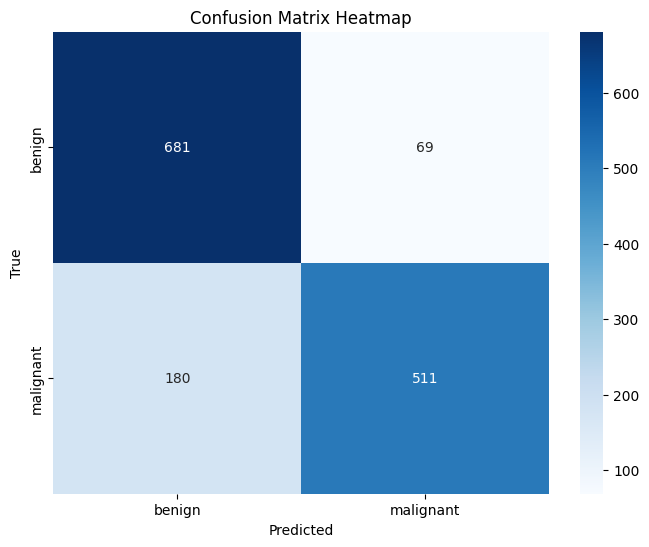

In [15]:
if __name__ == "__main__":
    # Paths to your data directories
    train_dir = os.path.join('data', 'train') # "/content/data/train"
    val_dir = os.path.join('data', 'val') # "/content/data/val"
    test_dir = os.path.join('data', 'test') # "/content/data/test"

    # Prepare data
    train_gen, val_gen, test_gen = prepare_data_generators(train_dir, val_dir, test_dir)

    # Choose number of classes
    num_classes = train_gen.num_classes

    # Train VGG16 model
    resnet50_model = create_resnet50_model(num_classes)
    trained_resnet50, _ = train_model(resnet50_model, train_gen, val_gen, epochs=100)
    save_model(trained_resnet50, "resnet50_model.h5")

    # Load and evaluate VGG16 model
    loaded_resnet50 = load_model("resnet50_model.h5")
    evaluate_model(loaded_resnet50, test_gen)

# Densenet

Found 5763 images belonging to 2 classes.
Found 2401 images belonging to 2 classes.
Found 1441 images belonging to 2 classes.
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 16s 1us/step
Epoch 1/100


E:\Projects\Project Melanoma-Skin-Cancer-Detection\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.7951 - loss: 0.4178 - val_accuracy: 0.8871 - val_loss: 0.2789
Epoch 2/100
 81/100 ━━━━━━━━━━━━━━━━━━━━ 10s 578ms/step - accuracy: 0.9007 - loss: 0.2492

E:\Projects\Project Melanoma-Skin-Cancer-Detection\venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 90s 906ms/step - accuracy: 0.8991 - loss: 0.2543 - val_accuracy: 0.8538 - val_loss: 0.3407
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.8945 - loss: 0.2634 - val_accuracy: 0.9042 - val_loss: 0.2437
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 90s 900ms/step - accuracy: 0.9054 - loss: 0.2383 - val_accuracy: 0.9017 - val_loss: 0.2414
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.9121 - loss: 0.2118 - val_accuracy: 0.9021 - val_loss: 0.2384
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 90s 904ms/step - accuracy: 0.9188 - loss: 0.2166 - val_accuracy: 0.9067 - val_loss: 0.2496
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.9043 - loss: 0.2233 - val_accuracy: 0.9063 - val_loss: 0.2286
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 89s 896ms/step - accuracy: 0.9133 - loss: 0.2166 - val_accuracy: 0.9050 - val_loss: 0.2448
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.9163 - loss: 0.2097 - val_

100/100 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9948 - loss: 0.0202 - val_accuracy: 0.9117 - val_loss: 0.3403
Epoch 52/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 91s 917ms/step - accuracy: 0.9963 - loss: 0.0165 - val_accuracy: 0.9075 - val_loss: 0.3527
Epoch 53/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.9937 - loss: 0.0210 - val_accuracy: 0.9109 - val_loss: 0.3746
Epoch 54/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 94s 947ms/step - accuracy: 0.9980 - loss: 0.0140 - val_accuracy: 0.9092 - val_loss: 0.3407
Epoch 55/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.9973 - loss: 0.0172 - val_accuracy: 0.9088 - val_loss: 0.3563
Epoch 56/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 93s 930ms/step - accuracy: 0.9954 - loss: 0.0171 - val_accuracy: 0.9071 - val_loss: 0.3633
Epoch 57/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.9962 - loss: 0.0179 - val_accuracy: 0.9071 - val_loss: 0.3781
Epoch 58/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 92s 919ms/step - accuracy: 0.9997 - loss: 0.0116

100/100 ━━━━━━━━━━━━━━━━━━━━ 92s 926ms/step - accuracy: 1.0000 - loss: 5.0358e-04 - val_accuracy: 0.9080 - val_loss: 0.4881


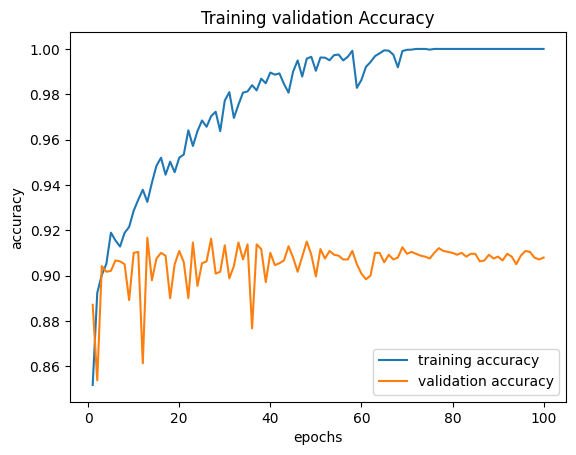

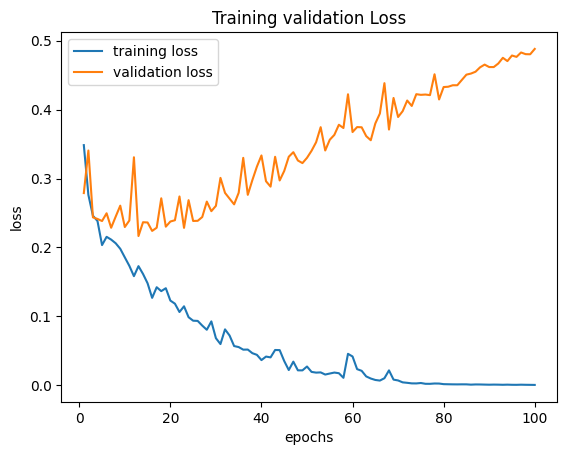

Model saved to densenet_model.h5


Model loaded from densenet_model.h5
46/46 ━━━━━━━━━━━━━━━━━━━━ 31s 632ms/step
Accuracy: 0.916030534351145
Loss: 0.08396946564885499
Cohen Kappa Score: 0.8316928402297752
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       750
           1       0.92      0.91      0.91       691

    accuracy                           0.92      1441
   macro avg       0.92      0.92      0.92      1441
weighted avg       0.92      0.92      0.92      1441



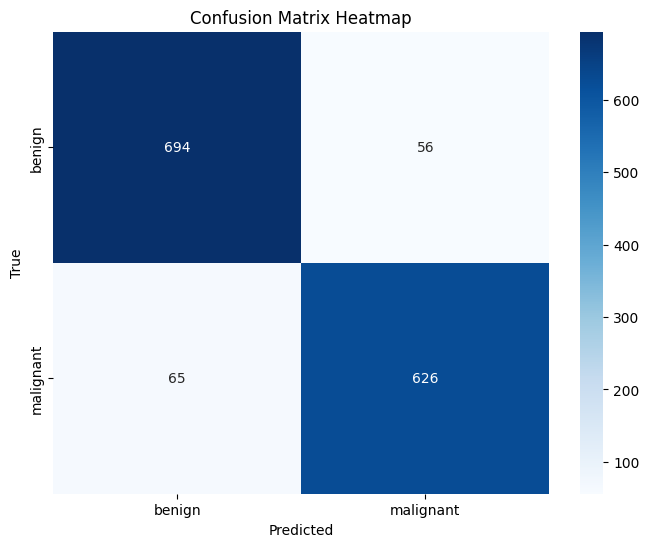

In [16]:
if __name__ == "__main__":
    # Paths to your data directories
    train_dir = os.path.join('data', 'train') # "/content/data/train"
    val_dir = os.path.join('data', 'val') # "/content/data/val"
    test_dir = os.path.join('data', 'test') # "/content/data/test"

    # Prepare data
    train_gen, val_gen, test_gen = prepare_data_generators(train_dir, val_dir, test_dir)

    # Choose number of classes
    num_classes = train_gen.num_classes

    # Train VGG16 model
    densenet_model = create_densenet_model(num_classes)
    trained_densenet, _ = train_model(densenet_model, train_gen, val_gen, epochs=100)
    save_model(trained_densenet, "densenet_model.h5")

    # Load and evaluate VGG16 model
    loaded_densenet = load_model("densenet_model.h5")
    evaluate_model(loaded_densenet, test_gen)

# Inceptionv3

Found 5763 images belonging to 2 classes.
Found 2401 images belonging to 2 classes.
Found 1441 images belonging to 2 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 162s 2us/step
Epoch 1/100


E:\Projects\Project Melanoma-Skin-Cancer-Detection\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 57s 535ms/step - accuracy: 0.7469 - loss: 0.6280 - val_accuracy: 0.8459 - val_loss: 0.3590
Epoch 2/100
 81/100 ━━━━━━━━━━━━━━━━━━━━ 5s 298ms/step - accuracy: 0.8744 - loss: 0.3065

E:\Projects\Project Melanoma-Skin-Cancer-Detection\venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 466ms/step - accuracy: 0.8739 - loss: 0.3064 - val_accuracy: 0.8709 - val_loss: 0.3100
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 520ms/step - accuracy: 0.8862 - loss: 0.2742 - val_accuracy: 0.8638 - val_loss: 0.3213
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 467ms/step - accuracy: 0.8916 - loss: 0.2620 - val_accuracy: 0.8834 - val_loss: 0.2952
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 519ms/step - accuracy: 0.8978 - loss: 0.2434 - val_accuracy: 0.8680 - val_loss: 0.3256
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 466ms/step - accuracy: 0.9018 - loss: 0.2348 - val_accuracy: 0.8651 - val_loss: 0.3111
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 523ms/step - accuracy: 0.8993 - loss: 0.2409 - val_accuracy: 0.8755 - val_loss: 0.2850
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 467ms/step - accuracy: 0.9110 - loss: 0.2208 - val_accuracy: 0.8717 - val_loss: 0.3191
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 522ms/step - accuracy: 0.8856 - loss: 0.265

100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 525ms/step - accuracy: 0.9896 - loss: 0.0284 - val_accuracy: 0.8817 - val_loss: 0.5060
Epoch 52/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 466ms/step - accuracy: 0.9990 - loss: 0.0084 - val_accuracy: 0.8792 - val_loss: 0.5558
Epoch 53/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 528ms/step - accuracy: 0.9987 - loss: 0.0096 - val_accuracy: 0.8825 - val_loss: 0.5083
Epoch 54/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 465ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.8771 - val_loss: 0.5283
Epoch 55/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 529ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.8821 - val_loss: 0.5417
Epoch 56/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 466ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.8867 - val_loss: 0.5305
Epoch 57/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 527ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.8842 - val_loss: 0.5463
Epoch 58/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 468ms/step - accuracy: 1.0000 - loss

100/100 ━━━━━━━━━━━━━━━━━━━━ 52s 523ms/step - accuracy: 1.0000 - loss: 2.0981e-04 - val_accuracy: 0.8855 - val_loss: 0.6842
Epoch 100/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 47s 468ms/step - accuracy: 1.0000 - loss: 1.7822e-04 - val_accuracy: 0.8846 - val_loss: 0.7005


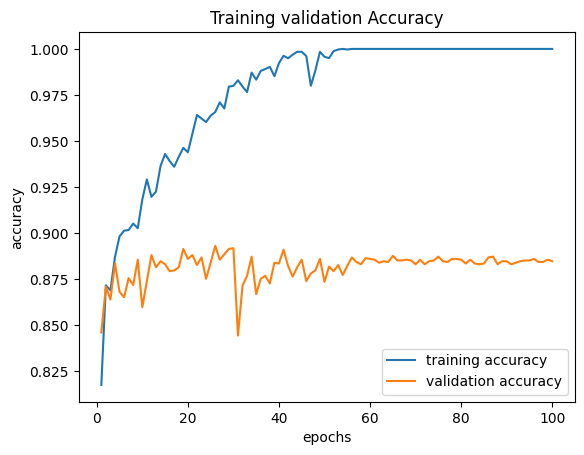

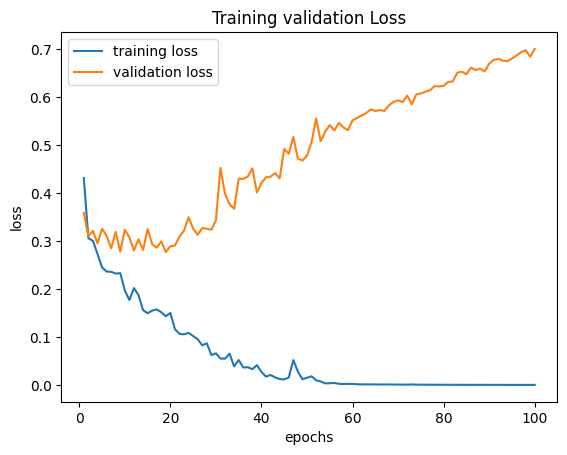

Model saved to inceptionv3_model.h5


Model loaded from inceptionv3_model.h5
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 316ms/step
Accuracy: 0.8945176960444136
Loss: 0.10548230395558644
Cohen Kappa Score: 0.7886570781815971
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90       750
           1       0.89      0.89      0.89       691

    accuracy                           0.89      1441
   macro avg       0.89      0.89      0.89      1441
weighted avg       0.89      0.89      0.89      1441



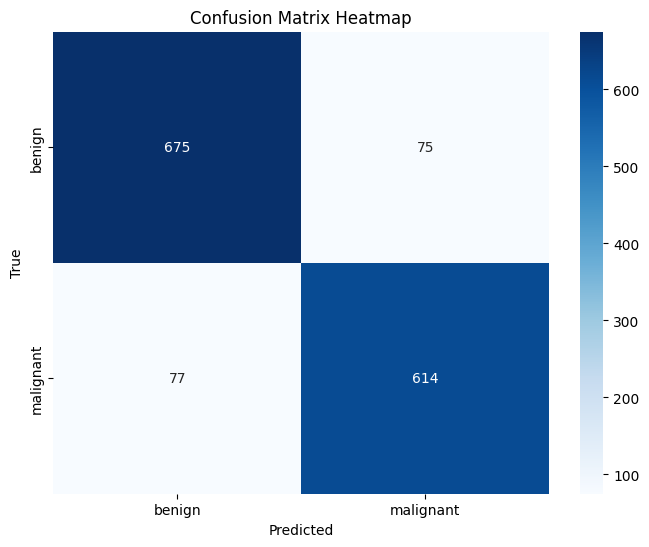

In [17]:
if __name__ == "__main__":
    # Paths to your data directories
    train_dir = os.path.join('data', 'train') # "/content/data/train"
    val_dir = os.path.join('data', 'val') # "/content/data/val"
    test_dir = os.path.join('data', 'test') # "/content/data/test"

    # Prepare data
    train_gen, val_gen, test_gen = prepare_data_generators(train_dir, val_dir, test_dir)

    # Choose number of classes
    num_classes = train_gen.num_classes

    # Train VGG16 model
    inceptionv3_model = create_inceptionv3_model(num_classes)
    trained_inceptionv3, _ = train_model(inceptionv3_model, train_gen, val_gen, epochs=100)
    save_model(trained_inceptionv3, "inceptionv3_model.h5")

    # Load and evaluate VGG16 model
    loaded_inceptionv3 = load_model("inceptionv3_model.h5")
    evaluate_model(loaded_inceptionv3, test_gen)

# Deployment

In [ ]:
!pip install tensorflow opencv-python-headless streamlit numpy pillow


In [ ]:
%%writefile app.py
import streamlit as st
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from PIL import Image

# Function to preprocess the image (including the inverse_masked_area)
def preprocess_image(image_path):
    """
    Preprocess the image and return the inverse masked area.

    Parameters:
        image_path (str): Path to the input image.

    Returns:
        inverse_masked_image (ndarray): Image with inverse masked area.
        processing_stages_path (str): Path to saved 'processing_stages.png'.
    """
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Convert to 256x256 grayscale
    gray_image = cv2.cvtColor(cv2.resize(image, (256, 256)), cv2.COLOR_BGR2GRAY)

    # Apply BM3D filtering
    denoised_image = cv2.fastNlMeansDenoising(gray_image, None, 10, 7, 21)

    # Apply binary thresholding
    _, binary_mask = cv2.threshold(denoised_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Perform morphological operations
    kernel = np.ones((5, 5), np.uint8)
    morphed_image = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    # Extract the masked area
    masked_area = cv2.bitwise_and(gray_image, gray_image, mask=morphed_image)

    # Extract the inverse of the masked area
    inverse_mask = cv2.bitwise_not(morphed_image)
    inverse_masked_area = cv2.bitwise_and(gray_image, gray_image, mask=inverse_mask)

    # Save all stages for visualization
    processing_stages_path = "processing_stages.png"
    stages = np.hstack((gray_image, morphed_image, masked_area, inverse_masked_area))
    cv2.imwrite(processing_stages_path, stages)

    return inverse_masked_area, processing_stages_path

# Prediction function using VGG16
def predict(image, model):
    """
    Predict using a pre-trained VGG16 model.

    Parameters:
        image (ndarray): Preprocessed image (inverse masked area).
        model (keras.Model): Pre-trained VGG16 model.

    Returns:
        str: Prediction result (e.g., 'Benign' or 'Malignant').
    """
    # Resize the image to match VGG16 input size (224x224)
    image_resized = cv2.resize(image, (224, 224))

    # Convert to 3-channel image (VGG16 expects RGB input)
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB)

    # Convert to array and preprocess for VGG16
    image_array = img_to_array(image_rgb)
    image_array = np.expand_dims(image_array, axis=0)
    image_preprocessed = preprocess_input(image_array)

    # Predict using the model
    predictions = model.predict(image_preprocessed)

    # Assume binary classification: class 0 = 'Benign', class 1 = 'Malignant'
    predicted_class = np.argmax(predictions, axis=1)[0]
    return "Malignant" if predicted_class == 1 else "Benign"

# Streamlit app
def main():
    st.title("Melanoma Skin Cancer Detection")
    st.write("Upload an image to detect melanoma skin cancer.")

    # Input image folder
    input_folder = "uploaded_images"
    if not os.path.exists(input_folder):
        os.makedirs(input_folder)

    # Load pre-trained VGG16 model
    # base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    # # Add custom classification layers
    # x = base_model.output
    # x = tf.keras.layers.Flatten()(x)
    # x = tf.keras.layers.Dense(256, activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    # predictions = tf.keras.layers.Dense(2, activation='softmax')(x)
    # vgg16_model = Model(inputs=base_model.input, outputs=predictions)
    # vgg16_model.load_weights("/content/processed_resnet50_model.h5")  # Load custom-trained weights

    vgg16_model = load_model(r'/content/processed_resnet50_model.h5')

    # File uploader
    uploaded_file = st.file_uploader("Choose an image", type=["jpg", "jpeg", "png"])

    if uploaded_file is not None:
        # Save the uploaded image
        image_path = os.path.join(input_folder, uploaded_file.name)
        with open(image_path, "wb") as f:
            f.write(uploaded_file.getbuffer())
        st.success(f"Image saved at {image_path}")

        # Display the uploaded image
        st.image(image_path, caption="Uploaded Image", use_column_width=True)

        # Preprocess the image
        st.write("Processing the image...")
        inverse_masked_image, processing_stages_path = preprocess_image(image_path)

        # Show processing stages
        st.write("Processing stages:")
        st.image(processing_stages_path, caption="Processing Stages", use_column_width=True)

        # Perform prediction
        st.write("Predicting...")
        result = predict(inverse_masked_image, vgg16_model)

        # Display the prediction result
        st.write(f"**Prediction Result:** {result}")

# Run the app
if __name__ == "__main__":
    main()


In [ ]:
!npm install localtunnel

 35.197.82.8

In [ ]:
import urllib
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

# !streamlit run app.py &>/content/logs.txt & npx localtunnel --port 8501
# !streamlit run app.py --server.address=localhost &>/content/logs.txt & npx localtunnel --port 8501
!streamlit run app.py & npx localtunnel --port 8501

# !pip install pyngrok
# from pyngrok import ngrok
# public_url = ngrok.connect(port='8501')
# print(public_url)
# !streamlit run app.py